In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip '/content/drive/MyDrive/MalImg dataset.zip'

Streaming output truncated to the last 5000 lines.
  inflating: dataset_9010/dataset_9010/malimg_dataset/train/Dontovo.A/0359f055545c068bf2bbfc686a87fca8.png  
  inflating: dataset_9010/dataset_9010/malimg_dataset/train/Dontovo.A/038096c3e054504ee06d15b2c9a3bc46.png  
  inflating: dataset_9010/dataset_9010/malimg_dataset/train/Dontovo.A/0383c95ca595cdda9e479cadbac72256.png  
  inflating: dataset_9010/dataset_9010/malimg_dataset/train/Dontovo.A/038d5ee2e815bc21d6b2abaf6efc8697.png  
  inflating: dataset_9010/dataset_9010/malimg_dataset/train/Dontovo.A/03a6be98f16f88cc9796017e8447fa93.png  
  inflating: dataset_9010/dataset_9010/malimg_dataset/train/Dontovo.A/03cb3315b58fb0a816ea4128d04f9666.png  
  inflating: dataset_9010/dataset_9010/malimg_dataset/train/Dontovo.A/03cdff68f939b90b2c32c7a5db664240.png  
  inflating: dataset_9010/dataset_9010/malimg_dataset/train/Dontovo.A/03e52e6dfa8ef26105a624a318dcd8ac.png  
  inflating: dataset_9010/dataset_9010/malimg_dataset/train/Dontovo.A/03fb98d

In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import keras
import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Dropout, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D
from keras import models, layers
from keras.layers import LSTM, TimeDistributed
from keras.callbacks import ReduceLROnPlateau,EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

In [5]:
train="/content/dataset_9010/dataset_9010/malimg_dataset/train"
val="/content/dataset_9010/dataset_9010/malimg_dataset/validation"
batch_size=32
IMAGE_SIZE=[150,150]

In [7]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    train,
    seed=123,
    shuffle=True,
    image_size=(150,150),
    batch_size=32
)

Found 8404 files belonging to 25 classes.


In [8]:
val_ds=tf.keras.preprocessing.image_dataset_from_directory(
    val,
    seed=123,
    shuffle=True,
    image_size=(150,150),
    batch_size=32
)

Found 935 files belonging to 25 classes.


In [9]:
class_names=dataset.class_names

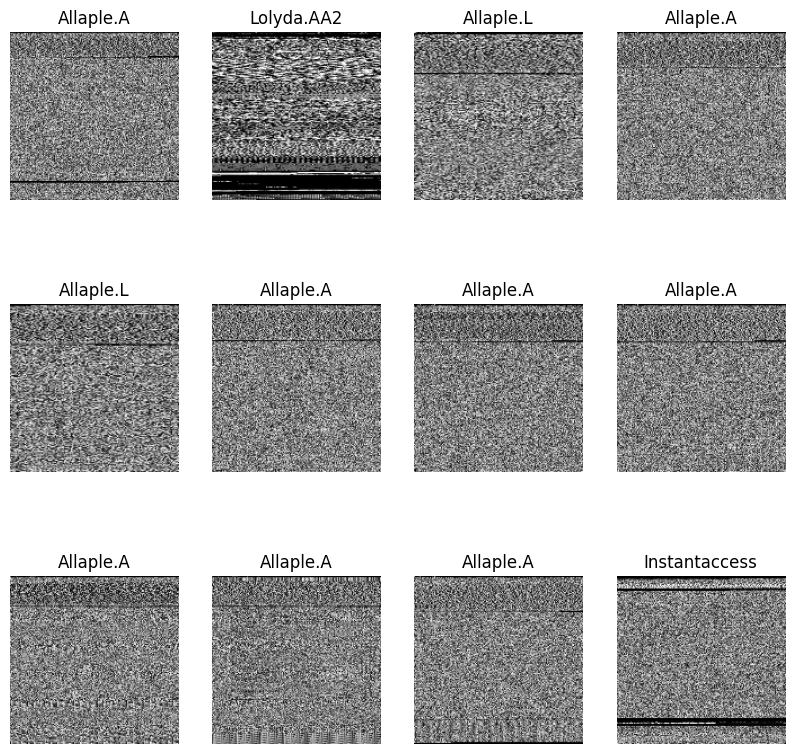

In [10]:
plt.figure(figsize=(10,10))
for image_batch, labels_batch in dataset.take(1):
  for i in range(12):
    ax=plt.subplot(3,4,i+1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.title(class_names[labels_batch[i]])
    plt.axis("off")

In [14]:
def get_dataset_partitions_tf(ds, train_split=0.7, test_split=0.3,shuffle=True,shuffle_size=10000):
  assert(train_split +test_split)==1
  ds_size=len(ds)
  if shuffle:
    ds=ds.shuffle(shuffle_size, seed=12)

  train_size=int(train_split *ds_size)
  test_size=int(test_split*ds_size)

  train_ds=ds.take(train_size)
  test_ds=ds.skip(train_size).take(test_size)

  return train_ds, test_ds


In [15]:
train_ds, test_ds= get_dataset_partitions_tf(dataset)

In [16]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [17]:
def model(width,height):
  model=Sequential()
  model.add(Conv2D(30, kernel_size=(3,3), activation='relu',input_shape=(width, height,3)))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Conv2D(15,(3,3),activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Flatten())
  model.add(Dropout(0.25))
  model.add(Dense(128, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(50,activation='relu'))
  model.add(Dense(25,activation='softmax'))
  model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),optimizer='adam', metrics=['accuracy'])
  return model

In [18]:
model=model(150,150)

In [21]:
model_fit=model.fit(train_ds, epochs=5, batch_size=32, validation_data=val_ds)

Epoch 1/5
184/184 [==============================] - 201s 1s/step - loss: 0.2708 - accuracy: 0.9251 - val_loss: 0.3136 - val_accuracy: 0.9112
Epoch 2/5
184/184 [==============================] - 160s 873ms/step - loss: 0.3043 - accuracy: 0.9195 - val_loss: 0.2926 - val_accuracy: 0.9059
Epoch 3/5
184/184 [==============================] - 177s 965ms/step - loss: 0.2188 - accuracy: 0.9369 - val_loss: 0.2228 - val_accuracy: 0.9251
Epoch 4/5
184/184 [==============================] - 216s 1s/step - loss: 0.1961 - accuracy: 0.9430 - val_loss: 0.2508 - val_accuracy: 0.9187
Epoch 5/5
184/184 [==============================] - 155s 843ms/step - loss: 0.1609 - accuracy: 0.9481 - val_loss: 0.2301 - val_accuracy: 0.9369


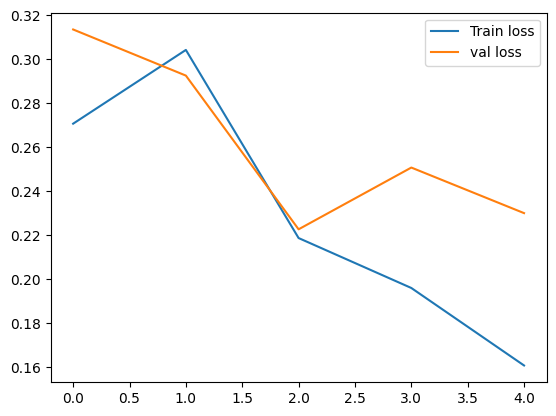

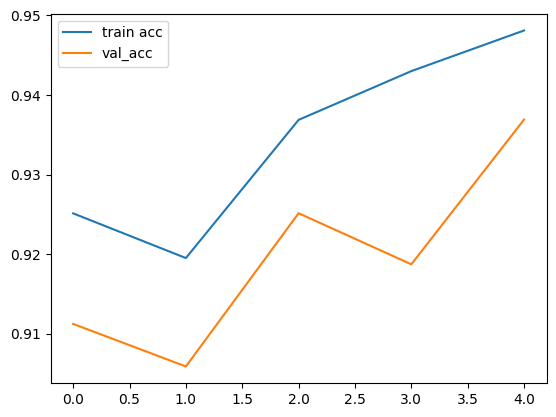

In [22]:
#plot the loss
plt.plot(model_fit.history['loss'],label='Train loss')
plt.plot(model_fit.history['val_loss'],label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss.jpg',format='jpg')

plt.close()
#plot the accuracy
plt.plot(model_fit.history['accuracy'], label='train acc')
plt.plot(model_fit.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc.jpg', format='jpg')

plt.close()

In [23]:
model.evaluate(test_ds)

78/78 [==============================] - 42s 225ms/step - loss: 0.0499 - accuracy: 0.9851


[0.04990372061729431, 0.9851046800613403]

In [25]:
from tensorflow.keras.preprocessing import image
img_path="/content/dataset_9010/dataset_9010/malimg_dataset/train/Obfuscator.AD/0038b67fb01f0b9b46cbf5238fe017f2.png"
img=image.load_img(img_path, target_size=(150,150))
img_tensor=image.img_to_array(img)
img_tensor=np.expand_dims(img_tensor,axis=0)

In [26]:
pred=model.predict(img_tensor)
print(class_names[np.argmax(pred)])

1/1 [==============================] - 0s 150ms/step
Obfuscator.AD


In [27]:
model.save("./MalwareDetector.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 194ms/step


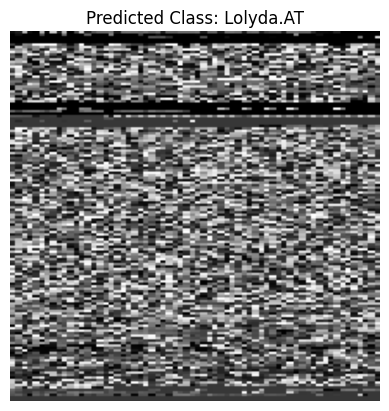

In [29]:
# Load the trained model
model = tf.keras.models.load_model("./MalwareDetector.h5")

# Function to preprocess the image
def preprocess_image(img_path, target_size=(150, 150)):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

# Function to predict class family for a given image
def predict_class_family(img_path, model):
    img_array = preprocess_image(img_path)
    pred = model.predict(img_array)
    return np.argmax(pred)

# Define the class names
class_names = ['Adialer.C','Agent.FYI','Allaple.A','Allaple.L','Alueron.gen!J','Autorun.K','C2LOP.gen!g','C2LOP.P','Dialplatform.B','Donvonto.A','Fakerean','Instantaccess',
               'Lolyda.AA1','Lolyda.AA2','Lolyda.AA3','Lolyda.AT','Malex.gen!J','Obfuscator.AD','Rbot!gen','Skintrim.N','Swizzor.gen!E','Swizzor.gen!I','VB.AT','Wintrim.BX',
               'Yuner.A']

# Function to display input image and predicted class family
def display_prediction(img_path, model):
    predicted_class = predict_class_family(img_path, model)
    img = image.load_img(img_path, target_size=(150, 150))
    plt.imshow(img)
    plt.title(f"Predicted Class: {class_names[predicted_class]}")
    plt.axis('off')
    plt.show()

# Provide the path of the image to be classified
img_path = "/content/dataset_9010/dataset_9010/malimg_dataset/train/Lolyda.AT/00079520833ea8ef25d68e552c00b2b2.png"  # Change this to the path of your image

# Display the prediction
display_prediction(img_path, model)